In [1]:
#Importing required libraries
import numpy as np
import random
from decimal import Decimal, ROUND_DOWN
import cmath

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Physical properties
wavelength = 813.4e-9   
focal_dist = 4e-3       #focal length of the lens
beam_width = 2e-3       #radius of the input beam
aperture = 4e-3         #aperture diameter of the lens


#Simulation variables
xmin = -50e-3   # Simulating 100X100 mm^2 grid
xmax = 50e-3
ymin = -50e-3
ymax = 50e-3
xlen = xmax-xmin  #calculating total length, later used to find dx
ylen = ymax-ymin


N = 4000      #X-Size of the matrix for performing simulation
M = 4000      #Y-Size of the matrix for performing simulation

dx = xlen/N   #X-Sampling size
dy = ylen/M   #Y-Sampling size

print(dx,dy)

x = np.arange(xmin,xmax,dx)   #X-line_space
y = np.arange(ymin,ymax,dy)   #Y-line_space


X,Y = np.meshgrid(x,y)   #defining meshgrid


def circ(x):    #Circ function for simulating aperture
    return  (abs(x)<=1/2).astype(np.int)


2.5e-05 2.5e-05


In [3]:
def fraunhofer(inp,xlen,ylen,wavelen,z):
    M,N = inp.shape

    dx = xlen/N    #finding sampling size
    dy = ylen/M
    
    k = 2*np.pi/wavelen  #wave-vector

    LX = wavelen*z/dx    #Calculating image plane X-Len 
    LY = wavelen*z/dy    #Calculating image plane Y-Len

    DX = wavelen*z/xlen  #Calculating image plane X-Sampling
    DY = wavelen*z/ylen  #Calculating image plane Y-Sampling
    
    x2 = np.arange(-LX/2,LX/2-(DX/2),DX)
    y2 = np.arange(-LY/2,LY/2-(DY/2),DY)
    
    X2,Y2 = np.meshgrid(x2,y2)  #meshgrid for image plane

    exp_term = 1/(1j*wavelen*z)
    
    outp = exp_term*np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(inp)))*dx*dy

    
    #print('X & Y side lengths = ' + str(LX) +' ' + str(LY))
    #print('X & Y sampling size = ' + str(DX) +' ' + str(DY))
    
    return outp,LX,LY,DX,DY,x2,y2

In [4]:
circular_ap = circ(((X**2 + Y**2)**0.5)/aperture)   #Amplitude mask for circular aperture
beam_rad = np.arange(1e-3,3.1e-3,0.1e-3)            #Array of beam radius to find optimal value
len(beam_rad)

21

In [5]:
peak_intensity = np.zeros(len(beam_rad))     #Array to store peak intensity values
transverse_profile = np.empty(len(beam_rad),dtype='object')   #To store focused beam profile, later used for axial propagation
for i in range(len(beam_rad)):
    normalizing_factor = (1e-3/((np.pi*beam_rad[i]**2)/2))   #normalzing to 1mW power
    input_beam = normalizing_factor*np.exp(-2*((X/beam_rad[i])**2 + (Y/(beam_rad[i]))**2))  #Intensity
    focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*circular_ap,xlen,ylen,wavelength,focal_dist)
    transverse_profile[i] = focused_beam     #Storing transverse profile (Note: don't use abs())
    peak_intensity[i] = abs(focused_beam**2).max()  #Extracting peak value

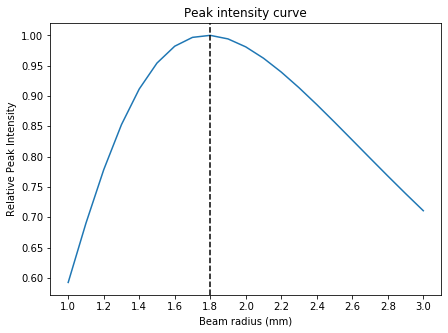

In [6]:
plt.figure(figsize = (7,5))
plt.title('Peak intensity curve')
plt.xlabel('Beam radius (mm)')
plt.xticks(np.arange(1,3.1,0.2))
plt.ylabel('Relative Peak Intensity')
plt.plot(1e3*beam_rad,peak_intensity/peak_intensity.max())   #Normalizing with the relatively highest peak
plt.axvline(x=1 + 0.1*(np.where(peak_intensity==peak_intensity.max())[0][0]),linestyle='dashed',color='black')

In [31]:
Transverse_2gradient = np.zeros(len(beam_rad))  #Array to store 2nd order derivative (at peak) of transverse profile
for i in range(len(beam_rad)):
    Transverse_2gradient[i] = abs(np.gradient(np.gradient(abs(transverse_profile[i]**2)[int(M/2)],DX),DX)[int(M/2)])

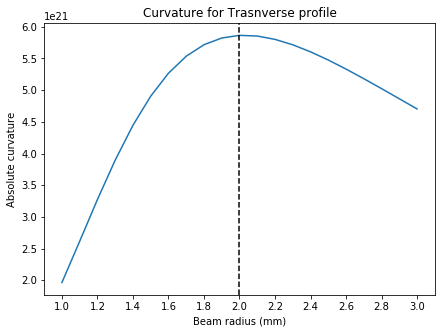

In [32]:
plt.figure(figsize = (7,5))
plt.title('Curvature for Trasnverse profile')
plt.xlabel('Beam radius (mm)')
plt.ylabel('Absolute curvature')
plt.plot(1e3*beam_rad,Transverse_2gradient)  #Plot for 2nd order derivative at peak (i.e. curvature)
plt.xticks(np.arange(1,3.1,0.2))
plt.axvline(x=1 + 0.1*(np.where(Transverse_2gradient==Transverse_2gradient.max())[0][0]),linestyle='dashed',color='black')

In [9]:
def Propagation(inp,xlen,ylen,wavelen,z):

    M,N = inp.shape

    dx = xlen/N  #calculating x-sampling
    dy = ylen/M  #calculating y-sampling
    
    k = 2*np.pi/wavelen  #wave-vector
    
    fx = np.arange(-1/(2*dx),1/(2*dx)-1/(2*xlen),1/xlen)   #fourier domain X-cordinates
    fy = np.arange(-1/(2*dy),1/(2*dy)-1/(2*ylen),1/ylen)   #fourier domain Y-cordinates

    FX,FY = np. meshgrid(fx,fy)   #meshgrid for fourier domain
    
    H = np.exp(-1j*np.pi*wavelen*z*(FX**2 + FY**2))   #Impulse response 
    
    H = np.fft.fftshift(H)
    
    U1 = np.fft.fft2(np.fft.fftshift(inp))     #Fourier transform of the input beam
    U2 = H*U1                                  #multiplication in fourier domain (convolution)
    outp = np.fft.ifftshift(np.fft.ifft2(U2))  #Coming back to spatial domain by taking IFT
    
    
    return outp

In [10]:
z = np.arange(-10e-6,10.01e-6,1e-7)   #Propagation distance -10um to 10um
len(z)  

201

In [16]:
#Propagating each focused beam profile (at different radius stored above) [this loop will take approx 30 minutes]

axial_profile = np.empty(len(beam_rad),dtype='object')  #Array to store axial profile of each input beam radius
for j in range(len(beam_rad)):
    print(j)
    propz = []
    for i in range(len(z)):
        prop = (Propagation(transverse_profile[j][1000:3000,1000:3000],LX/2,LY/2,wavelength,z[i])) #Propagating only the central region
        propz.append(abs(abs(prop[int(len(prop)/2)])))
    propz = np.transpose(propz)
    axial_profile[j] = abs(propz[1000])  #Storing values only for Y=0 cut

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [35]:
Axial_2gradient = np.zeros(len(beam_rad))  #Array to store 2nd order derivate (at peak) for axial profile
for i in range(len(beam_rad)):
    Axial_2gradient[i] = abs(np.gradient(np.gradient(abs(axial_profile[i]**2),DX),DX)[100])

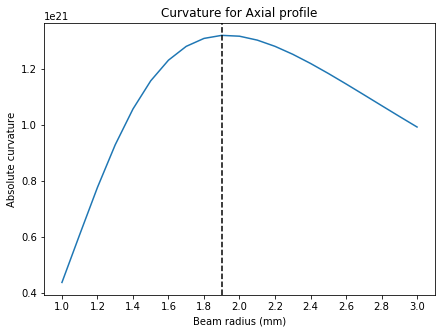

In [38]:
plt.figure(figsize = (7,5))
plt.title('Curvature for Axial profile')
plt.xlabel('Beam radius (mm)')
plt.ylabel('Absolute curvature')
plt.plot(1e3*beam_rad,Axial_2gradient)
plt.xticks(np.arange(1,3.1,0.2))
plt.axvline(x=1 + 0.1*(np.where(Axial_2gradient==Axial_2gradient.max())[0][0]),linestyle='dashed',color='black')